## Import required libraries

In [48]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### ET ref Function of ET by AAyoub. (Fao-56)

In [49]:
import pandas as pd
import numpy as np
from math import pi, cos, sin, acos, exp, log, sqrt, tan


def ETref(df, lat, elevation):
    """
    This function takes a DataFrame and adds various calculated columns
    for meteorological and agricultural research.
    """
    # Julian Date (day)
    ###
    # Julian Date represents the number of days since January 1st of each year.
    df['Julian Date (day)'] = (
        df['Date'] - pd.to_datetime(df['Date'].dt.year.astype(str) + '-01-01')).dt.days + 1

    # U2 (Wind Speed at 2m) in meters per second (m/s)
    # Formula: U2 = U3 * (4.87 / ln(67.8 * 3 - 5.42))
    df['U2 (m/s)'] = df['U3_m_s-1'] * (4.87 / np.log(67.8 * 10 - 5.42))#because windspeed gems height is at 10m

    # Rs (Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rs = G * 0.0864
    df['Rs (MJ/m²/day)'] = df['Rs_W_m2'] * 0.0864

    # # Rhmax_adj (Adjusted Max Relative Humidity) in percentage (%)
    # # Formula: Rhmax_adj = min(Rh_max, 100)
    # df['Rhmax_adj (%)'] = np.minimum(df['Rhmax_%'], 100)

    # # Rh_avg (Average Relative Humidity) in percentage (%)
    # # Formula: Rh_avg = (Rh_min + Rhmax_adj) / 2
    # df['Rh_avg (%)'] = (df['Rhmin_%'] + df['Rhmax_adj (%)']) / 2

    # Tavg (Average Temperature) in degrees Celsius (°C)
    # Formula: Tavg = (Tmin + Tmax) / 2
    df['Tavg (°C)'] = (df['Tmax_C'] + df['Tmin_C']) / 2
    df['Tavg (°C)'] = pd.to_numeric(df['Tavg (°C)'], errors='raise')

    # Lambda (λ) in MegaJoules per kilogram (MJ/kg)
    # Formula: Lambda = 2.501 - (2.361e-3 * Tavg)
    df['Lambda (MJ/kg)'] = 2.501 - (2.361e-3 * df['Tavg (°C)'])

    # P (Atmospheric Pressure) in kiloPascals (kPa)
    # Formula: P = 101.3 * ((293 - 0.0065 * 552) / 293)^5.26
    df['P (kPa)'] = 101.3 * ((293 - 0.0065 * elevation) / 293)**5.26  # correct

    # Gamma (ϒ) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Gamma = (1.013 * P) / (0.622 * Lambda) * 1e-3
    df['Gamma (kPa/°C)'] = ((1.013 * 1e-3 * df['P (kPa)']) /
                            (0.622 * df['Lambda (MJ/kg)']))

    # Delta (∆) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Delta = (4098 * (0.6108 * exp(17.27 * Tavg / (Tavg + 237.3)))) / (Tavg + 237.3)^2
    df['Delta (kPa/°C)'] = (4098 * (0.6108 * np.exp(17.27 * df['Tavg (°C)'] /
                                                    (df['Tavg (°C)'] + 237.3)))) / ((df['Tavg (°C)'] + 237.3)**2)

    # eᵒ(Tmax) (Saturation Vapor Pressure at Tmax) in kiloPascals (kPa)
    # Formula: eᵒ(Tmax) = 0.6108 * exp(17.27 * Tmax / (Tmax + 237.3))
    df['eᵒ(Tmax) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmax_C'] / (df['Tmax_C'] + 237.3))

    # eᵒ(Tmin) (Saturation Vapor Pressure at Tmin) in kiloPascals (kPa)
    # Formula: eᵒ(Tmin) = 0.6108 * exp(17.27 * Tmin / (Tmin + 237.3))
    df['eᵒ(Tmin) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmin_C'] / (df['Tmin_C'] + 237.3))

    # eᵒs (Average Saturation Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒs = (eᵒ(Tmax) + eᵒ(Tmin)) / 2
    df['eᵒs (kPa)'] = (df['eᵒ(Tmax) (kPa)'] + df['eᵒ(Tmin) (kPa)']) / 2

    # eᵒa (Actual Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒa = eᵒs * (Rh_avg / 100)
    # df['eᵒa (kPa)'] = ((df['eᵒ(Tmin) (kPa)'] * (df['Rhmax_adj (%)']/100)
    #                     ) + (df['eᵒ(Tmax) (kPa)'] * (df['Rhmin_%']/100)))/2
    df['eᵒa (kPa)']=0.6108*np.exp(17.27*df["T_dew_C"]/(df["T_dew_C"]+237.3))
    # VPD (Vapor Pressure Deficit) in kiloPascals (kPa)
    # Formula: VPD = eᵒs - eᵒa
    df['VPD (kPa)'] = df['eᵒs (kPa)'] - df['eᵒa (kPa)']

    # dr (Inverse Relative Distance Earth-Sun)
    # Formula: dr = 1 + 0.033 * cos(2π * Julian Date (day) / 365)
    df['Inverse Relative Distance Earth-Sun'] = 1 + 0.033 * \
        np.cos(2 * np.pi * df['Julian Date (day)'] / 365)

    # δ (Solar Declination) in radians (rad)
    # Formula: δ = 0.409 * sin(2π * Julian Date (day) / 365 - 1.39)
    df['Solar Declination (rad)'] = 0.409 * np.sin((2 *
                                                    np.pi * df['Julian Date (day)'] / 365) - 1.39)

    # ωs (Sunset Hour Angle) in radians (rad)
    # Formula: ωs = acos(-tan(lat) * tan(δ))
    df['Sunset Hour Angle (rad)'] = np.arccos(-np.tan(lat)
                                              * np.tan(df['Solar Declination (rad)']))

    # Ra (Extraterrestrial Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Ra = (24 * 60 / π) * Gsc * dr * (ws*sin(lat) * sin(δ) + cos(lat) * cos(δ) * sin(ωs))
    df['Ra (MJ/m²/day)'] = (24 * 60 / np.pi) * 0.082 * df['Inverse Relative Distance Earth-Sun'] * (df['Sunset Hour Angle (rad)']*np.sin(lat)
                                                                                                    * np.sin(df['Solar Declination (rad)']) + (np.cos(lat) * np.cos(df['Solar Declination (rad)']) * np.sin(df['Sunset Hour Angle (rad)'])))

    # Rso (Clear Sky Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rso = (0.75 + 2e-5 * 552) * Ra
    df['Rso (MJ/m²/day)'] = (0.75 + 2e-5 * elevation) * df['Ra (MJ/m²/day)']

    # Rns (Net Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rns = (1 - 0.23) * Rs
    df['Rns (MJ/m²/day)'] = (1 - 0.23) * \
        df['Rs (MJ/m²/day)']  # we need alfaalfa albedo

    # Rnl (Net Longwave Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rnl = (4.903e-9 * ((Tavg + 273.16)^4 + (Tmin + 273.16)^4) / 2 * (0.34 - 0.14 * sqrt(eᵒa)) * (1.35 * Rns / Rso) - 0.35)
    df['Rnl (MJ/m²/day)'] = (4.903e-9 * ((df['Tavg (°C)'] + 273.16)**4 + (df['Tmin_C'] + 273.16)**4) / 2) * (0.34 -
                                                                                                             0.14 * np.sqrt(df['eᵒa (kPa)'])) * ((1.35 * np.minimum(df['Rs (MJ/m²/day)'] / df['Rso (MJ/m²/day)'], 1) - 0.35))

    # Rn (Net Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rn = Rns - Rnl
    df['Rn (MJ/m²/day)'] = df['Rns (MJ/m²/day)'] - df['Rnl (MJ/m²/day)']

    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    df['ETo (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)']))
    # ETo (Reference Evapotranspiration) in inches per day (in/day)
    #df['ETo (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)'])) * 0.0393701

    #ETr (Reference Evapotranspiration for grass) in millimeters per day (mm/day)
    #df['ETr (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)']))
    # ETr (Reference Evapotranspiration for grass) in millimeters per day (in/day)
    #df['ETr (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          # * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)'])) * 0.0393701

    return df


In [50]:
# Load the CSV file from GEMS data
df_GEMS_Becker2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Becker_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Clarissa2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Clarissa2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Dakota2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Hubbard2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Hubbard_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_LittleFalls2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_LittleFalls_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_OtterTail2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_OtterTail_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_ParkersPrairie2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_ParkersPrairie_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Perham2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Perham_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_PinePoint2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_PinePoint_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Rice2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Rice_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Staples2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Staples_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Wadena2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Wadena_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Westport2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Westport_2022-01-01_to_2022-12-31_units(M).csv')
df_GEMS_Becker2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Becker_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Clarissa2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Dakota2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Hubbard2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Hubbard_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_LittleFalls2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_LittleFalls_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_OtterTail2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_OtterTail_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_ParkersPrairie2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_ParkersPrairie_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Perham2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Perham_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_PinePoint2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_PinePoint_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Rice2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Rice_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Staples2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Staples_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Wadena2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Wadena_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Douglas2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Wadena_2023-01-01_to_2023-12-31_units(M).csv')
df_GEMS_Westport2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Westport_2023-01-01_to_2023-12-31_units(M).csv')

In [51]:
#Load csv file from MDA data
df_BeckerMDA_2022 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2022.csv')
df_BeckerMDA_2023 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2023.csv')
df_ClarissaMDA_2022 = pd.read_csv('MDAclean_data/Clarissa_clean_MDA_2022.csv')
df_ClarissaMDA_2023 = pd.read_csv('MDAclean_data/Clarissa_clean_MDA_2023.csv')
df_HastingsMDA_2022 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2022.csv')
df_HastingsMDA_2023 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2023.csv')
df_HubbardMDA_2022 = pd.read_csv('MDAclean_data/Hubbard_clean_MDA_2022.csv')
df_HubbardMDA_2023 = pd.read_csv('MDAclean_data/Hubbard_clean_MDA_2023.csv')
df_LittleFallsMDA_2022 = pd.read_csv('MDAclean_data/LittleFalls_clean_MDA_2022.csv')
df_LittleFallsMDA_2023 = pd.read_csv('MDAclean_data/LittleFalls_clean_MDA_2023.csv')
df_OtterTailMDA_2022 = pd.read_csv('MDAclean_data/Ottertail_clean_MDA_2022.csv')
df_OtterTailMDA_2023 = pd.read_csv('MDAclean_data/Ottertail_clean_MDA_2023.csv')
df_ParkersPrairieMDA_2022 = pd.read_csv('MDAclean_data/ParkersPrairie_clean_MDA_2022.csv')
df_ParkersPrairieMDA_2023 = pd.read_csv('MDAclean_data/ParkersPrairie_clean_MDA_2023.csv')
df_PerhamMDA_2022 = pd.read_csv('MDAclean_data/Perham_clean_MDA_2022.csv')
df_PerhamMDA_2023 = pd.read_csv('MDAclean_data/Perham_clean_MDA_2023.csv')
df_PinePointMDA_2022 = pd.read_csv('MDAclean_data/PinePoint_clean_MDA_2022.csv')
df_PinePointMDA_2023 = pd.read_csv('MDAclean_data/PinePoint_clean_MDA_2023.csv')
df_RiceMDA_2022 = pd.read_csv('MDAclean_data/Rice_clean_MDA_2022.csv')
df_RiceMDA_2023 = pd.read_csv('MDAclean_data/Rice_Clean_MDA_2023.csv')
df_StaplesMDA_2022 = pd.read_csv('MDAclean_data/Staples_clean_MDA_2022.csv')
df_StaplesMDA_2023 = pd.read_csv('MDAclean_data/Staples_clean_MDA_2023.csv')
df_WadenaMDA_2022 = pd.read_csv('MDAclean_data/Wadena_clean_MDA_2022.csv')
df_WadenaMDA_2023 = pd.read_csv('MDAclean_data/Wadena_clean_MDA_2023.csv')
df_WestportMDA_2022 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2022.csv')
df_WestportMDA_2023 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2023.csv')

### Calculating ETo for all stations in mm for 2022 and 2023

In [52]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Becker2022['Date'] = pd.to_datetime(df_GEMS_Becker2022['Date'])

#Rename columns if necessary
df_GEMS_Becker2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.792 #  latitude of the location in radian
elevation = 287  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Becker2022 = ETref(df_GEMS_Becker2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Becker2022.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738   -22.2  67   987      342 2022-01-01   
1             1      1   4753   -17.2  70   988      344 2022-01-02   
2             2      2   4770    -4.4  74   983      345 2022-01-03   
3             3      3   4787    -2.2  81   968      347 2022-01-04   
4             4      4   4806    -8.3  76   975      349 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678   -11.2  66   986      337 2022-12-26   
360         360    360   4687    -1.9  71   969      337 2022-12-27   
361         361    361   4697     2.8  77   959      338 2022-12-28   
362         362    362   4708     0.8  86   966      339 2022-12-29   
363         363    363   4721    -6.0  77   977      340 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             3.0         0.0  ...   0.030626   
1             2.0  

In [53]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Becker2023['Date'] = pd.to_datetime(df_GEMS_Becker2023['Date'])

# Rename columns if necessary
df_GEMS_Becker2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                   'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                   'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.792  # Latitude of the location in radian
elevation = 287   # The actual elevation of the location in meters (same as Becker)

# Call the ETref function
df_GEMS_Becker2023 = ETref(df_GEMS_Becker2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Becker2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738     1.0  87   975      342 2023-01-01   
1             1      1   4753    -4.2  90   981      344 2023-01-02   
2             2      2   4770    -0.6  89   970      345 2023-01-03   
3             3      3   4787     0.2  89   969      347 2023-01-04   
4             4      4   4806    -3.0  85   977      349 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678     7.5  87   974      337 2023-12-26   
360         360    360   4687     1.1  89   981      337 2023-12-27   
361         361    361   4697     2.1  89   982      338 2023-12-28   
362         362    362   4708     5.7  81   977      339 2023-12-29   
363         363    363   4721     0.0  83   974      340 2023-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             3.7         0.0  ...   0.106479   
1             2.3  

In [54]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Clarissa2022['Date'] = pd.to_datetime(df_GEMS_Clarissa2022['Date'])

# Rename columns if necessary
df_GEMS_Clarissa2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                     'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                     'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.805  # Latitude of the location in radian
elevation = 397   # The actual elevation of the location in meters (Clarissa-specific)

# Call the ETref function
df_GEMS_Clarissa2022 = ETref(df_GEMS_Clarissa2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Clarissa2022.head)

# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Clarissa2023['Date'] = pd.to_datetime(df_GEMS_Clarissa2023['Date'])

# Rename columns if necessary
df_GEMS_Clarissa2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                     'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                     'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.805  # Latitude of the location in radian
elevation = 397   # The actual elevation of the location in meters (Clarissa-specific)

# Call the ETref function
df_GEMS_Clarissa2023 = ETref(df_GEMS_Clarissa2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Clarissa2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4657   -24.4  68   972      329 2022-01-01   
1             1      1   4673   -16.3  71   971      331 2022-01-02   
2             2      2   4689    -7.0  78   967      332 2022-01-03   
3             3      3   4707    -5.9  83   955      334 2022-01-04   
4             4      4   4725    -9.6  76   963      336 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4593   -13.7  71   974      324 2022-12-26   
360         360    360   4603    -4.4  77   954      325 2022-12-27   
361         361    361   4614     2.2  84   946      325 2022-12-28   
362         362    362   4626    -1.9  87   955      326 2022-12-29   
363         363    363   4639    -7.0  79   964      328 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             4.0         0.0  ...   0.023843   
1             4.4  

In [55]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Dakota2022['Date'] = pd.to_datetime(df_GEMS_Dakota2022['Date'])

# Rename columns if necessary
df_GEMS_Dakota2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                   'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                   'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.7794  # Latitude of the location in radian
elevation = 249    # The actual elevation of the location in meters (Dakota-specific)

# Call the ETref function
df_GEMS_Dakota2022 = ETref(df_GEMS_Dakota2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Dakota2022.head)

# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Dakota2023['Date'] = pd.to_datetime(df_GEMS_Dakota2023['Date'])

# Rename columns if necessary
df_GEMS_Dakota2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                   'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                   'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.7794  # Latitude of the location in radian
elevation = 249    # The actual elevation of the location in meters (Dakota-specific)

# Call the ETref function
df_GEMS_Dakota2023 = ETref(df_GEMS_Dakota2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Dakota2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4814   -17.0  70   992      350 2022-01-01   
1             1      1   4830   -16.3  69   995      352 2022-01-02   
2             2      2   4846    -4.1  70   989      353 2022-01-03   
3             3      3   4864    -0.4  79   974      355 2022-01-04   
4             4      4   4884    -3.3  79   979      357 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4757   -11.5  71   994      344 2022-12-26   
360         360    360   4765    -5.2  70   980      345 2022-12-27   
361         361    361   4774     2.2  74   969      346 2022-12-28   
362         362    362   4785     1.9  86   974      347 2022-12-29   
363         363    363   4797    -2.6  80   985      348 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             4.4         0.0  ...   0.045574   
1             3.6  

In [56]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Hubbard2022['Date'] = pd.to_datetime(df_GEMS_Hubbard2022['Date'])

# Rename columns if necessary
df_GEMS_Hubbard2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                    'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                    'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.804  # Latitude of the location in radian
elevation = 397   # The actual elevation of the location in meters (Hubbard-specific)

# Call the ETref function
df_GEMS_Hubbard2022 = ETref(df_GEMS_Hubbard2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Hubbard2022.head)

# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_Hubbard2023['Date'] = pd.to_datetime(df_GEMS_Hubbard2023['Date'])

# Rename columns if necessary
df_GEMS_Hubbard2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                    'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                    'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.804  # Latitude of the location in radian
elevation = 397   # The actual elevation of the location in meters (Hubbard-specific)

# Call the ETref function
df_GEMS_Hubbard2023 = ETref(df_GEMS_Hubbard2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Hubbard2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4505   -23.3  81   968      311 2022-01-01   
1             1      1   4522   -18.3  78   966      312 2022-01-02   
2             2      2   4540    -7.8  80   963      314 2022-01-03   
3             3      3   4559    -6.7  84   952      315 2022-01-04   
4             4      4   4578   -11.1  73   960      317 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4438   -12.8  70   969      305 2022-12-26   
360         360    360   4448    -6.1  79   949      306 2022-12-27   
361         361    361   4460    -1.1  87   943      307 2022-12-28   
362         362    362   4472    -3.3  92   951      308 2022-12-29   
363         363    363   4486    -8.9  84   959      309 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             4.0         0.0  ...   0.023921   
1             5.8  

In [57]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_LittleFalls2022['Date'] = pd.to_datetime(df_GEMS_LittleFalls2022['Date'])

# Rename columns if necessary
df_GEMS_LittleFalls2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                        'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                        'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.8005  # Latitude of the location in radian
elevation = 338    # The actual elevation of the location in meters (LittleFalls-specific)

# Call the ETref function
df_GEMS_LittleFalls2022 = ETref(df_GEMS_LittleFalls2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_LittleFalls2022.head)

# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_LittleFalls2023['Date'] = pd.to_datetime(df_GEMS_LittleFalls2023['Date'])

# Rename columns if necessary
df_GEMS_LittleFalls2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                        'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                        'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.8005  # Latitude of the location in radian
elevation = 338    # The actual elevation of the location in meters (LittleFalls-specific)

# Call the ETref function
df_GEMS_LittleFalls2023 = ETref(df_GEMS_LittleFalls2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_LittleFalls2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4637   -22.0  68   981      329 2022-01-01   
1             1      1   4653   -18.0  72   981      330 2022-01-02   
2             2      2   4670    -5.0  81   976      332 2022-01-03   
3             3      3   4688    -6.0  84   963      333 2022-01-04   
4             4      4   4707    -9.0  77   971      335 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4571   -12.0  67   982      323 2022-12-26   
360         360    360   4581    -5.0  75   963      324 2022-12-27   
361         361    361   4592     1.0  85   955      325 2022-12-28   
362         362    362   4605    -1.0  92   964      326 2022-12-29   
363         363    363   4618    -8.0  79   972      327 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             3.2         0.0  ...   0.032231   
1             3.4  

In [58]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_OtterTail2022['Date'] = pd.to_datetime(df_GEMS_OtterTail2022['Date'])

# Rename columns if necessary
df_GEMS_OtterTail2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                      'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                      'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.81021  # Latitude of the location in radian
elevation = 413     # The actual elevation of the location in meters (OtterTail-specific)

# Call the ETref function
df_GEMS_OtterTail2022 = ETref(df_GEMS_OtterTail2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_OtterTail2022.head)

# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_OtterTail2023['Date'] = pd.to_datetime(df_GEMS_OtterTail2023['Date'])

# Rename columns if necessary
df_GEMS_OtterTail2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                      'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                      'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.81021  # Latitude of the location in radian
elevation = 413     # The actual elevation of the location in meters (OtterTail-specific)

# Call the ETref function
df_GEMS_OtterTail2023 = ETref(df_GEMS_OtterTail2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_OtterTail2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4576   -25.9  71   970      319 2022-01-01   
1             1      1   4592   -17.0  72   968      320 2022-01-02   
2             2      2   4609    -9.3  77   965      322 2022-01-03   
3             3      3   4627    -7.0  84   954      323 2022-01-04   
4             4      4   4646   -10.4  76   963      325 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4511   -15.6  72   971      313 2022-12-26   
360         360    360   4521    -5.2  78   951      314 2022-12-27   
361         361    361   4532     1.1  85   944      315 2022-12-28   
362         362    362   4544    -2.6  88   953      316 2022-12-29   
363         363    363   4558    -8.5  81   962      317 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             3.6         0.0  ...   0.019802   
1             4.4  

In [59]:
# Load the CSV file# Make sure 'Date' is in datetime format
df_GEMS_ParkersPrairie2022['Date'] = pd.to_datetime(df_GEMS_ParkersPrairie2022['Date'])

# Rename columns if necessary
df_GEMS_ParkersPrairie2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                           'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                           'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.80542
elevation = 448

# Call the ETref function
df_GEMS_ParkersPrairie2022 = ETref(df_GEMS_ParkersPrairie2022, latitude, elevation)

print(df_GEMS_ParkersPrairie2022.head)


# Perham
df_GEMS_Perham2022['Date'] = pd.to_datetime(df_GEMS_Perham2022['Date'])
df_GEMS_Perham2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                   'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                   'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.805
elevation = 448
df_GEMS_Perham2022 = ETref(df_GEMS_Perham2022, latitude, elevation)
print(df_GEMS_Perham2022.head)


# PinePoint
df_GEMS_PinePoint2022['Date'] = pd.to_datetime(df_GEMS_PinePoint2022['Date'])
df_GEMS_PinePoint2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                      'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                      'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.8205
elevation = 476
df_GEMS_PinePoint2022 = ETref(df_GEMS_PinePoint2022, latitude, elevation)
print(df_GEMS_PinePoint2022.head)


# Rice
df_GEMS_Rice2022['Date'] = pd.to_datetime(df_GEMS_Rice2022['Date'])
df_GEMS_Rice2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                 'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.798
elevation = 328
df_GEMS_Rice2022 = ETref(df_GEMS_Rice2022, latitude, elevation)
print(df_GEMS_Rice2022.head)


# Staples
df_GEMS_Staples2022['Date'] = pd.to_datetime(df_GEMS_Staples2022['Date'])
df_GEMS_Staples2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                    'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                    'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.80925
elevation = 391
df_GEMS_Staples2022 = ETref(df_GEMS_Staples2022, latitude, elevation)
print(df_GEMS_Staples2022.head)


# Wadena
df_GEMS_Wadena2022['Date'] = pd.to_datetime(df_GEMS_Wadena2022['Date'])
df_GEMS_Wadena2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                   'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                   'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.81034
elevation = 416
df_GEMS_Wadena2022 = ETref(df_GEMS_Wadena2022, latitude, elevation)
print(df_GEMS_Wadena2022.head)


# Westport
df_GEMS_Westport2022['Date'] = pd.to_datetime(df_GEMS_Westport2022['Date'])
df_GEMS_Westport2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1',
                                     'solar_rad': 'Rs_W_m2', 'max_temp': 'Tmax_C',
                                     'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

latitude = 0.796
elevation = 409
df_GEMS_Westport2022 = ETref(df_GEMS_Westport2022, latitude, elevation)
print(df_GEMS_Westport2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4669   -25.2  69   967      329 2022-01-01   
1             1      1   4685   -16.3  70   965      331 2022-01-02   
2             2      2   4701    -7.4  77   962      332 2022-01-03   
3             3      3   4718    -6.3  83   951      334 2022-01-04   
4             4      4   4736   -10.0  76   959      336 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4608   -14.8  71   968      324 2022-12-26   
360         360    360   4617    -4.4  77   949      325 2022-12-27   
361         361    361   4627     1.9  85   941      325 2022-12-28   
362         362    362   4639    -2.2  88   950      326 2022-12-29   
363         363    363   4652    -7.8  80   959      328 2022-12-30   

     max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0             3.6         0.0  ...   0.021160   
1             4.8  

In [60]:
import pandas as pd

# ParkersPrairie
df_GEMS_ParkersPrairie2023['Date'] = pd.to_datetime(df_GEMS_ParkersPrairie2023['Date'])
df_GEMS_ParkersPrairie2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                           'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.80542
elevation = 448
df_GEMS_ParkersPrairie2023 = ETref(df_GEMS_ParkersPrairie2023, latitude, elevation)
print(df_GEMS_ParkersPrairie2023.head())

# Perham
df_GEMS_Perham2023['Date'] = pd.to_datetime(df_GEMS_Perham2023['Date'])
df_GEMS_Perham2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                   'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.805
elevation = 448
df_GEMS_Perham2023 = ETref(df_GEMS_Perham2023, latitude, elevation)
print(df_GEMS_Perham2023.head())

# PinePoint
df_GEMS_PinePoint2023['Date'] = pd.to_datetime(df_GEMS_PinePoint2023['Date'])
df_GEMS_PinePoint2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                      'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.8205
elevation = 476
df_GEMS_PinePoint2023 = ETref(df_GEMS_PinePoint2023, latitude, elevation)
print(df_GEMS_PinePoint2023.head())

# Rice
df_GEMS_Rice2023['Date'] = pd.to_datetime(df_GEMS_Rice2023['Date'])
df_GEMS_Rice2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                 'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.798
elevation = 328
df_GEMS_Rice2023 = ETref(df_GEMS_Rice2023, latitude, elevation)
print(df_GEMS_Rice2023.head())

# Staples
df_GEMS_Staples2023['Date'] = pd.to_datetime(df_GEMS_Staples2023['Date'])
df_GEMS_Staples2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                    'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.80925
elevation = 391
df_GEMS_Staples2023 = ETref(df_GEMS_Staples2023, latitude, elevation)
print(df_GEMS_Staples2023.head())

# Wadena
df_GEMS_Wadena2023['Date'] = pd.to_datetime(df_GEMS_Wadena2023['Date'])
df_GEMS_Wadena2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                   'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.81034
elevation = 416
df_GEMS_Wadena2023 = ETref(df_GEMS_Wadena2023, latitude, elevation)
print(df_GEMS_Wadena2023.head())

# Westport
df_GEMS_Westport2023['Date'] = pd.to_datetime(df_GEMS_Westport2023['Date'])
df_GEMS_Westport2023.rename(columns={'wind_spd': 'U3_m_s-1', 'solar_rad': 'Rs_W_m2',
                                     'max_temp': 'Tmax_C', 'min_temp': 'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)
latitude = 0.796
elevation = 409
df_GEMS_Westport2023 = ETref(df_GEMS_Westport2023, latitude, elevation)
print(df_GEMS_Westport2023.head())


   Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0           0      0   4669    -2.6  90   958      329 2023-01-01   
1           1      1   4685    -5.9  91   964      331 2023-01-02   
2           2      2   4701    -6.3  88   956      332 2023-01-03   
3           3      3   4718    -4.8  84   956      334 2023-01-04   
4           4      4   4736    -7.0  84   961      336 2023-01-05   

   max_wind_spd  precip_gpm  ...  VPD (kPa)  \
0           4.0         0.0  ...   0.068970   
1           2.0         0.0  ...   0.025820   
2           5.6         7.5  ...   0.025640   
3           5.2         5.5  ...   0.057501   
4           3.6         0.0  ...   0.054828   

   Inverse Relative Distance Earth-Sun  Solar Declination (rad)  \
0                             1.032995                -0.401008   
1                             1.032980                -0.399564   
2                             1.032956                -0.398001   
3                             1.03

## For GEMS 2022 and MDA 2022 comparing Gridded and non-gridded ETo for 2022

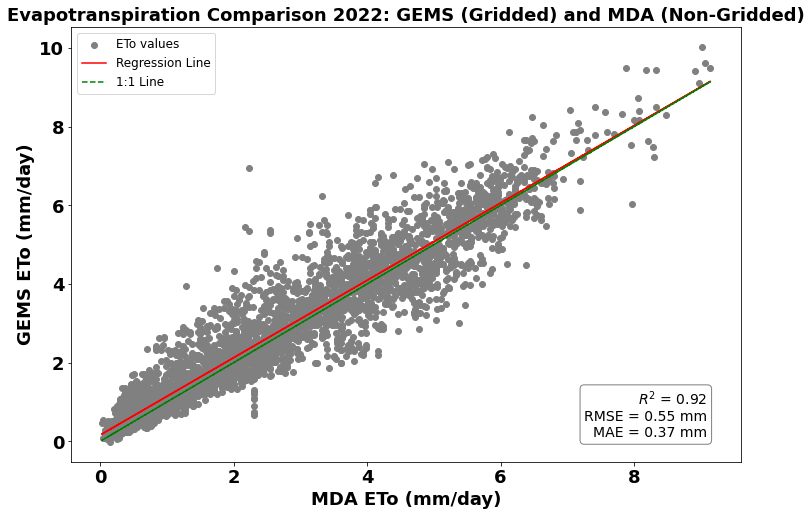

Pearson correlation coefficient: 0.9598125940605423
P-value: 0.0000000000


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr 

# Define the locations and corresponding dataframes
locations = [
    ("Becker22", df_BeckerMDA_2022, df_GEMS_Becker2022),
    ("Clarissa22", df_ClarissaMDA_2022, df_GEMS_Clarissa2022),
    ("Hubbard22", df_HubbardMDA_2022, df_GEMS_Hubbard2022),
    ("Dakota22", df_HastingsMDA_2022, df_GEMS_Dakota2022),
    ("LittleFalls22", df_LittleFallsMDA_2022, df_GEMS_LittleFalls2022),
    ("Ottertail22", df_OtterTailMDA_2022, df_GEMS_OtterTail2022),
    ("ParkersPrairie22", df_ParkersPrairieMDA_2022, df_GEMS_ParkersPrairie2022),
    ("Perham22", df_PerhamMDA_2022, df_GEMS_Perham2022),
    ("PinePoint22", df_PinePointMDA_2022, df_GEMS_PinePoint2022),
    ("Rice22", df_RiceMDA_2022, df_GEMS_Rice2022),
    ("Staples22", df_StaplesMDA_2022, df_GEMS_Staples2022),
    ("Wadena22", df_WadenaMDA_2022, df_GEMS_Wadena2022),
    ("Westport22", df_WestportMDA_2022, df_GEMS_Westport2022)
]

# Combine all data
all_mda_eto = np.array([])
all_gems_eto = np.array([])

for _, df_MDA, df_GEMS in locations:
    # Convert MDA ETo from inches to mm/day (1 inch = 25.4 mm), ensuring numeric conversion
    mda_eto_mm = pd.to_numeric(df_MDA['ETos_daily_in'], errors='coerce') * 25.4  
    gems_eto_mm = pd.to_numeric(df_GEMS['ETo (mm/day)'], errors='coerce')  # Ensure numeric format

    # Handling missing values with imputation
    imputer = SimpleImputer(strategy='mean')
    mda_eto_mm_imputed = imputer.fit_transform(mda_eto_mm.values.reshape(-1, 1)).flatten()
    gems_eto_mm_imputed = imputer.fit_transform(gems_eto_mm.values.reshape(-1, 1)).flatten()

    all_mda_eto = np.concatenate([all_mda_eto, mda_eto_mm_imputed])
    all_gems_eto = np.concatenate([all_gems_eto, gems_eto_mm_imputed])

# Fit linear regression model
model = LinearRegression()
model.fit(all_mda_eto.reshape(-1, 1), all_gems_eto)

# Calculate metrics
predictions = model.predict(all_mda_eto.reshape(-1, 1))
r2 = r2_score(all_gems_eto, predictions)
mae = mean_absolute_error(all_gems_eto, predictions)
rmse = np.sqrt(mean_squared_error(all_gems_eto, predictions))

# Plot settings
plt.figure(figsize=(12, 8))
plt.scatter(all_mda_eto, all_gems_eto, color='gray', label='ETo values')
plt.plot(all_mda_eto, predictions, color='red', label='Regression Line')
plt.plot(all_mda_eto, all_mda_eto, color='green', linestyle='--', label='1:1 Line')
plt.xlabel('MDA ETo (mm/day)', fontsize=18, fontweight='bold')
plt.ylabel('GEMS ETo (mm/day)', fontsize=18, fontweight='bold')
plt.title('Evapotranspiration Comparison 2022: GEMS (Gridded) and MDA (Non-Gridded)', fontsize=18, fontweight='bold')

# Customizing tick parameters
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# Legend
plt.legend(fontsize=12, loc='upper left')

# Grid
plt.grid(False)

# Annotations with formatted R2, RMSE, and MAE
textstr = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} mm\nMAE = {mae:.2f} mm'
plt.text(0.95, 0.05, textstr, verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

# Saving and showing the plot
plt.savefig('ET_Comparison_2022_mm.png', dpi=300)
plt.show()

# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(all_mda_eto, all_gems_eto)

# Print Pearson correlation coefficient and p-value with 10 decimal places
print("Pearson correlation coefficient:", pearson_corr)
print("P-value:", "{:.10f}".format(p_value))



### Comparing GEMS (Gridded) and MDA(point) ETo 2023

📊 Processing Becker23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Clarissa23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Hubbard23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Dakota23: MDA Shape = (363, 27), GEMS Shape = (363, 59)
📊 Processing LittleFalls23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Ottertail23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing ParkersPrairie23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Perham23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing PinePoint23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Rice23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Staples23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Wadena23: MDA Shape = (364, 27), GEMS Shape = (364, 59)
📊 Processing Westport23: MDA Shape = (364, 75), GEMS Shape = (364, 59)
✅ Final dataset shape: MDA = 4727, GEMS = 4727


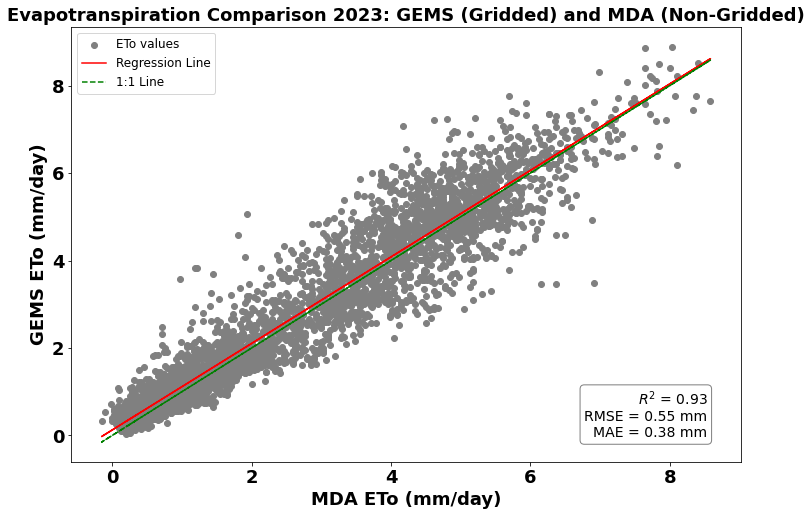

Pearson correlation coefficient: 0.9622154505237479
P-value: 0.0000000000


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr 

# Define the locations and corresponding dataframes for 2023
locations = [
    ("Becker23", df_BeckerMDA_2023, df_GEMS_Becker2023),
    ("Clarissa23", df_ClarissaMDA_2023, df_GEMS_Clarissa2023),
    ("Hubbard23", df_HubbardMDA_2023, df_GEMS_Hubbard2023),
    ("Dakota23", df_HastingsMDA_2023, df_GEMS_Dakota2023),
    ("LittleFalls23", df_LittleFallsMDA_2023, df_GEMS_LittleFalls2023),
    ("Ottertail23", df_OtterTailMDA_2023, df_GEMS_OtterTail2023),
    ("ParkersPrairie23", df_ParkersPrairieMDA_2023, df_GEMS_ParkersPrairie2023),
    ("Perham23", df_PerhamMDA_2023, df_GEMS_Perham2023),
    ("PinePoint23", df_PinePointMDA_2023, df_GEMS_PinePoint2023),
    ("Rice23", df_RiceMDA_2023, df_GEMS_Rice2023),
    ("Staples23", df_StaplesMDA_2023, df_GEMS_Staples2023),
    ("Wadena23", df_WadenaMDA_2023, df_GEMS_Wadena2023),
    ("Westport23", df_WestportMDA_2023, df_GEMS_Westport2023)
]

# Combine all data
all_mda_eto = np.array([])
all_gems_eto = np.array([])

for location, df_MDA, df_GEMS in locations:
    # Ensure both DataFrames have the same length
    min_length = min(len(df_MDA), len(df_GEMS))
    df_MDA = df_MDA.iloc[:min_length]  # Trim extra rows if needed
    df_GEMS = df_GEMS.iloc[:min_length]

    print(f"📊 Processing {location}: MDA Shape = {df_MDA.shape}, GEMS Shape = {df_GEMS.shape}")

    # Convert MDA ETo from inches to mm/day (1 inch = 25.4 mm), ensuring numeric conversion
    mda_eto_mm = pd.to_numeric(df_MDA['ETos_daily_in'], errors='coerce') * 25.4  
    gems_eto_mm = pd.to_numeric(df_GEMS['ETo (mm/day)'], errors='coerce')  # Ensure numeric format

    # Drop NaNs to maintain consistency
    combined_df = pd.DataFrame({'mda_eto': mda_eto_mm, 'gems_eto': gems_eto_mm}).dropna()

    # Handling missing values with imputation
    imputer = SimpleImputer(strategy='mean')
    mda_eto_mm_imputed = imputer.fit_transform(combined_df['mda_eto'].values.reshape(-1, 1)).flatten()
    gems_eto_mm_imputed = imputer.fit_transform(combined_df['gems_eto'].values.reshape(-1, 1)).flatten()

    # Ensure lengths are equal before concatenation
    if len(mda_eto_mm_imputed) == len(gems_eto_mm_imputed):
        all_mda_eto = np.concatenate([all_mda_eto, mda_eto_mm_imputed])
        all_gems_eto = np.concatenate([all_gems_eto, gems_eto_mm_imputed])
    else:
        print(f"⚠ Warning: Skipping {location} due to length mismatch after cleaning.")

# Ensure final arrays are equal in length
if len(all_mda_eto) != len(all_gems_eto):
    min_length = min(len(all_mda_eto), len(all_gems_eto))
    all_mda_eto = all_mda_eto[:min_length]
    all_gems_eto = all_gems_eto[:min_length]

print(f"✅ Final dataset shape: MDA = {len(all_mda_eto)}, GEMS = {len(all_gems_eto)}")

# Fit linear regression model
model = LinearRegression()
model.fit(all_mda_eto.reshape(-1, 1), all_gems_eto)

# Calculate metrics
predictions = model.predict(all_mda_eto.reshape(-1, 1))
r2 = r2_score(all_gems_eto, predictions)
mae = mean_absolute_error(all_gems_eto, predictions)
rmse = np.sqrt(mean_squared_error(all_gems_eto, predictions))

# Plot settings
plt.figure(figsize=(12, 8))
plt.scatter(all_mda_eto, all_gems_eto, color='gray', label='ETo values')
plt.plot(all_mda_eto, predictions, color='red', label='Regression Line')
plt.plot(all_mda_eto, all_mda_eto, color='green', linestyle='--', label='1:1 Line')
plt.xlabel('MDA ETo (mm/day)', fontsize=18, fontweight='bold')
plt.ylabel('GEMS ETo (mm/day)', fontsize=18, fontweight='bold')
plt.title('Evapotranspiration Comparison 2023: GEMS (Gridded) and MDA (Non-Gridded)', fontsize=18, fontweight='bold')

# Customizing tick parameters
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# Legend
plt.legend(fontsize=12, loc='upper left')

# Grid
plt.grid(False)

# Annotations with formatted R2, RMSE, and MAE
textstr = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} mm\nMAE = {mae:.2f} mm'
plt.text(0.95, 0.05, textstr, verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

# Saving and showing the plot
plt.savefig('ET_Comparison_2023_mm.png', dpi=300)
plt.show()

# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(all_mda_eto, all_gems_eto)

# Print Pearson correlation coefficient and p-value with 10 decimal places
print("Pearson correlation coefficient:", pearson_corr)
print("P-value:", "{:.10f}".format(p_value))
